In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from math import floor, ceil
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import geopandas as gpd

In [5]:
df = pd.read_table("../RawDataSets/ebd_sancra_smp_relApr-2024.txt", 
                   delimiter = '\t', 
                   usecols = ["LATITUDE", 
                              "LONGITUDE", 
                              "OBSERVATION DATE", 
                              "ALL SPECIES REPORTED"])

#When using for actual data, remove nrows = 10000
df.columns = [col.title() for col in df.columns]
df = df.rename(columns = {"All Species Reported": "Observed"})

In [6]:
df[["Year", "Month", "Day"]] = df["Observation Date"].str.split( '-', expand = True) # Split Date into Year, Month, Day

df = df.dropna(subset = ["Year", "Month", "Day"]) # Remove NA Dates

df[["Year", "Month", "Day"]] = df[["Year", "Month", "Day"]].astype(int) # Convert These to integers

#df = df.query('2015 <= Year <= 2020') #Year above a certain point for time series analysis bc of lack of  data

df = df.loc[(df["Longitude"] <= -50) & (df["Longitude"] >= -180)] #Focus on Just North America 

df.head()

,Latitude,Longitude,Observation Date,Observed,Year,Month,Day
0,32.316913,-64.744706,1993-10-28,1.0,1993,10,28
1,32.316913,-64.744706,1993-10-25,1.0,1993,10,25
2,32.307955,-64.754791,1993-10-15,0.0,1993,10,15
3,32.307955,-64.754791,1993-10-12,0.0,1993,10,12
4,32.375395,-64.660635,1993-10-09,0.0,1993,10,9


### Note on Longitude and Latitude
PLease for the love of god remember that Longitude is the X axis. The lines go up and down like an X intercept. 
All Coordinates should be of the form (Longitude, Latitude).


In [7]:
def check_cell(sample_size, cell_area, df):
    #cell_area has the elkements (long lower bound, lat lower bound, height, width)
    #sample_size has elements [Minimum observation count, minimum day count]
    inlat = (df["Latitude"] <= cell_area[1] + cell_area[3]) & (df["Latitude"] >= cell_area[1])
    inlong = (df["Longitude"] <= cell_area[0] + cell_area[2]) & (df["Longitude"] >= cell_area[0])
    present = (df["Observed"] == 1)
    
    temp = df[inlat & inlong & present].groupby(["Year", "Month", "Day"]).size().reset_index(name = 'count')
    return len(temp) > sample_size[1]

def expand_cells(cell_breaks, length):
    pointer = 0
    while cell_breaks[pointer] + length < cell_breaks[-1]:
        cell_breaks.insert(pointer + 1, cell_breaks[pointer] + length)
        pointer += 1
    return cell_breaks

min_long = floor(min(df["Longitude"])) 
max_long = ceil(max(df["Longitude"]))
min_lat = floor(min(df["Latitude"]))
max_lat = ceil(max(df["Latitude"]))

maxes = (max_lat, max_long)
mins = (min_lat, min_long)
cells_long = [min_long, max_long]
cells_lat = [min_lat, max_lat]

cells_long = expand_cells(cells_long,  1)
cells_lat = expand_cells(cells_lat, 1)

all_cells = []
for j in range(len(cells_lat) - 1):
    for i in range(len(cells_long) - 1):
        all_cells.append([ cells_long[i], cells_lat[j], 1, 1])

        
all_cells = np.array(all_cells)
'''
Next steps: 
    Merge non meeting cells with those that do meet
    Compute Covariance Matrix 
'''

'\nNext steps: \n    Merge non meeting cells with those that do meet\n    Compute Covariance Matrix \n'

In [7]:
GoodCells = []
for cell in all_cells:
    GoodCells.append([
        (cell[0], cell[1]), check_cell([30,60], cell, df)])


C:\Users\bobby\AppData\Local\Temp\ipykernel_31704\759076050.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


NameError: name 'GoodCells' is not defined

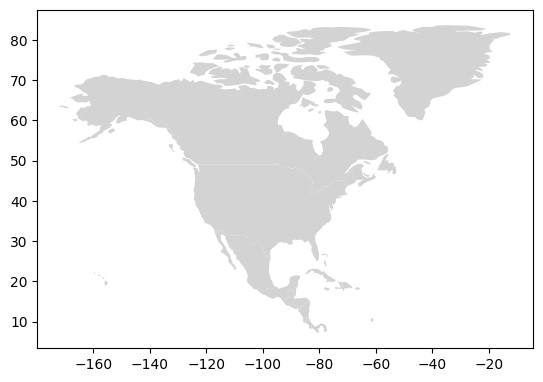

In [14]:
red = lambda good: 'blue' if good == True else 'none'
fig = plt.figure()
ax = fig.add_subplot(111)
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries[countries["continent"] == "North America"].plot(ax = ax, color = "lightgray")
for cell, goodness in GoodCells:
    rect = patches.Rectangle(cell, 1,1, linewidth = .1, edgecolor = 'black', facecolor = red(goodness))
    
    ax.add_patch(rect)
ax.autoscale()
plt.ylim((18, 85))
plt.xlim((-180, -48))
plt.show()

<Axes: xlabel='Year', ylabel='Month'>

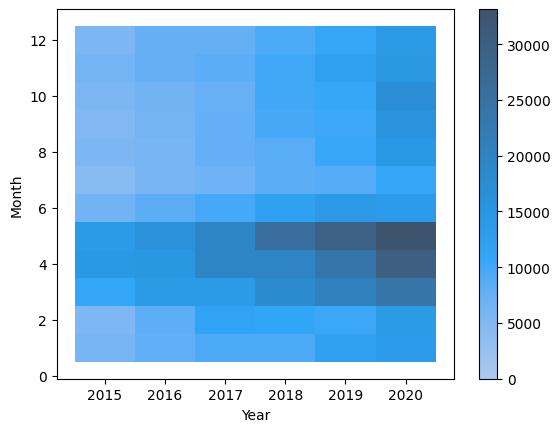

In [9]:
sns.histplot(data = df, x = "Year", y = "Month", binwidth = 1, discrete = (True, True), cbar = True)


In [8]:
def merge_cells_eastwest(cell_list, longwest, latwest, longeast, lateast):
    #steps: Find the east and west row index
    westindex = np.where((cell_list[:,0] == longwest) & (cell_list[:,1] == latwest))[0][0]
    eastindex = np.where((cell_list[:,0] == longeast) & (cell_list[:,1] == lateast))[0][0]
    
    #add east width to west width
    cell_list[westindex, 2] = cell_list[westindex,2] + cell_list[eastindex, 2]
    
    #delete the east index
    cell_list = np.delete(cell_list, eastindex, axis = 0)

    return cell_list

def merge_cells_northsouth(cell_list, lat, height):
    #Lat is the southern cells Latitude
    #Height is the height of the southern cell
    
    newlat = lat + height
    
    #Find cells directly above
    to_merge = cell_list[cell_list[:,1] == newlat]
    
    #find breaks 
    breaks = to_merge[:, (0,2,3)]
    
    #Remove all old cells
    cell_list = cell_list[(cell_list[:, 1] != newlat) & (cell_list[:,1] != lat)]
    
    #Create new array
    merged = np.insert(breaks, 1, lat, axis = 1)
    merged[:, 3] = merged[:, 3] + height
 
    
    return np.concatenate((cell_list, merged))

def search_cells(cell_list, sample_size,df = df):
    #Each cell should be formatted as: (longmin, latmin, width, height)
    rowno = 0
    while rowno < cell_list.shape[0]:
        cell = cell_list[rowno, :]
        good = check_cell(sample_size, cell, df)
        #ORder of Checks for not good cells:
        #First, Check if there is a cell directly east, if so merge
        #Second, because there is no cell directly east, we check if there is a cell to the west. If so merge
        #Finally, if no cells east or west, then we have a latitude band
            #To deal with this, we look north first, if we have a row above us, then we extend that row down by height degrees
            #If we looked north and there is no row, do the same thing but with south. 
        
        #If not check.size == 0 sees whether or not the array is empty. I use this bc north south merges 
        #can be complex so it maintains formatting.
        
        if not good: # THis means the cell needs to be merged
            #Check east.
            east_check = cell_list[(cell_list[:, 0] == cell[0] + cell[2]) & (cell_list[:, 1] == cell[1])].flatten()
            if not east_check.size == 0:
                cell_list = merge_cells_eastwest(cell_list, cell[0], cell[1], east_check[0], east_check[1])
            else:
                #Check West
                west_check = cell_list[(cell_list[:,0] + cell_list[:, 2] == cell[0]) & (cell_list[:, 1] == cell[1])].flatten()
                if not west_check.size == 0:
                    cell_list = merge_cells_eastwest(cell_list, west_check[0], west_check[1], cell[0], cell[1])
                
                else:
                    #We have a lateral band, so we want to look above/below and expand that row.
                    north_check = cell_list[(cell_list[:, 1] == cell[1] + cell[3])].flatten()
                    if not north_check.size == 0:
                        cell_list = merge_cells_northsouth(cell_list, cell[1], cell[3])
                        
                    else:
                        #We have nothing above, so we want to see which row touches the bottom.
                        south_check = cell_list[((cell_list[:, 1] + cell_list[:, 3]) == cell[1])]
                        cell_list = merge_cells_northsouth(cell_list, south_check[0,1], south_check[0,3])
        rowno += 1
    return cell_list


In [ ]:
red = lambda good: 'blue' if good == True else 'none'
GoodNewCells = pd.DataFrame(data = new, columns = ["Long", "Lat", "Width", "Height"])
GoodNewCells["Goodness"] = GoodNewCells.apply(lambda g: check_cell([30,60], g, df), axis = 1)
GoodNewCells["geometry"] = GoodNewCells.apply(lambda g: patches.Rectangle((g[0], g[1]), g[2], g[3], linewidth = 0.1, edgecolor = "black", facecolor = red(g[4])), axis = 1)


fig = plt.figure()
ax = fig.add_subplot(111)
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
countries[countries["continent"] == "North America"].plot(ax = ax, color = "lightgray")

for shape in GoodNewCells.geometry:
    ax.add_patch(shape)

ax.autoscale()
plt.ylim((18, 85))
plt.xlim((-180, -48))
plt.show()

In [ ]:
fig, ax = plt.subplots(3,2, figsize = (18,27))

countries[countries["continent"] == "North America"].plot(ax = ax[0,0], color = "lightgray")
for cell, goodness in GoodCells:
    rect = patches.Rectangle(cell, 1,1, linewidth = .1, edgecolor = 'black', facecolor = red(goodness))
    
    ax[0,0].add_patch(rect)

ax[0, 0].title.set_text(f'Iteration 0')
ax[0, 0].set_xlim((-180,-45))
ax[0, 0].set_ylim((18,85))
for i in range(1,6):
    col = i % 2
    row = i // 2
    countries[countries["continent"] == "North America"].plot(ax = ax[row, col], color = "lightgray")
    if i == 1:
        new = search_cells(all_cells, [30, 60], df)
    else:
        new = search_cells(new, [30, 60], df)
    
    GoodNewCells = pd.DataFrame(data = new, columns = ["Long", "Lat", "Width", "Height"])
    GoodNewCells["Goodness"] = GoodNewCells.apply(lambda g: check_cell([30,60], g, df), axis = 1)
    GoodNewCells["geometry"] = GoodNewCells.apply(lambda g: patches.Rectangle((g[0], g[1]), g[2], g[3], linewidth = 0.1, edgecolor = "black", facecolor = red(g[4])), axis = 1)
    
    for shape in GoodNewCells.geometry:
        ax[row, col].add_patch(shape)
        
    ax[row, col].title.set_text(f'Iteration {i}')
    ax[row, col].set_xlim((-180,-45))
    ax[row, col].set_ylim((18,85))
plt.show()

In [10]:
prev = all_cells
while True:
    curr = search_cells(prev, [30,180], df)
    if curr.size == prev.size:
        break
    else:
        prev = curr
    

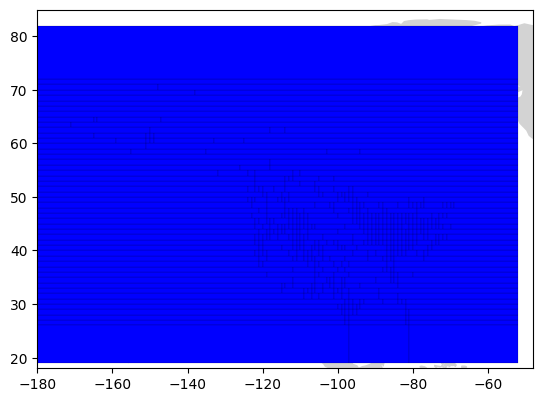

In [16]:
red = lambda good: 'blue' if good == True else 'none'
Cells = pd.DataFrame(data = curr, columns = ["Long", "Lat", "Width", "Height"])
Cells["Goodness"] = Cells.apply(lambda g: check_cell([30,180], g, df), axis = 1)
Cells["geometry"] = Cells.apply(lambda g: patches.Rectangle((g[0], g[1]), g[2], g[3], linewidth = 0.1, edgecolor = "black", facecolor = red(g[4])), axis = 1)


fig = plt.figure()
ax = fig.add_subplot(111)
countries[countries["continent"] == "North America"].plot(ax = ax, color = "lightgray")

for shape in Cells.geometry:
    ax.add_patch(shape)

ax.autoscale()
plt.ylim((18, 85))
plt.xlim((-180, -48))
plt.show()

In [22]:
import networkx as nx

g = nx.Graph()

In [17]:
def check_touching_cells(cell, cell_list):
    cell_list = cell_list[cell_list['id'] != cell[6]]
    edges = []
    for index, cell2 in cell_list.iterrows():
        if cell2[1] == cell[1] and cell2[0] + cell2[2] == cell[0]: 
                #If they are in the same row, and touch horisontally
                edges.append([cell[6], cell2[6]])
        elif cell2[1] + cell2[3] == cell[1]:
            if cell2[0] >= cell[0] and cell2[0] <= cell[0] + cell[2]:
                #If cell2 touches cell from the bottom and cell2 starts in the middle of cell
                edges.append([cell[6], cell2[6]])
            elif cell2[0] + cell2[2] >= cell[0] and cell2[0] + cell2[2]  <= cell[0] + cell[2]:
                edges.append([cell[6], cell2[6]])
            elif cell2[0] <= cell[0] and cell2[0] <= cell[0] + cell[2] and cell2[0] + cell2[2] >= cell[0] and cell2[0] + cell2[2] >= cell[0] + cell[2]:
                edges.append([cell[6], cell2[6]])
    
    return edges
Cells['id'] = np.arange(len(Cells))
Cells['LatMax'] = Cells['Lat'] + Cells['Height']
Cells['LongMax'] = Cells['Long'] + Cells['Width']
Cells.head()

,Long,Lat,Width,Height,Goodness,geometry,id,LatMax,LongMax
0,-180,26,82,1,True,"Rectangle(xy=(-180, 26), width=82, height=1, a...",0,27,-98
1,-98,26,1,1,True,"Rectangle(xy=(-98, 26), width=1, height=1, ang...",1,27,-97
2,-97,26,15,1,True,"Rectangle(xy=(-97, 26), width=15, height=1, an...",2,27,-82
3,-82,26,1,1,True,"Rectangle(xy=(-82, 26), width=1, height=1, ang...",3,27,-81
4,-81,26,29,1,True,"Rectangle(xy=(-81, 26), width=29, height=1, an...",4,27,-52


In [23]:
g.add_nodes_from([i for i in range(len(Cells))])

In [18]:
dates = df["Observation Date"].unique()
CellList = np.arange(len(Cells))
all_time_cells = [[cell, date] for cell in CellList for date in dates]
Countdf = pd.DataFrame(data = all_time_cells, columns = ['ID', "Observation Date"])

In [19]:
def find_cell(cell, Cells = Cells):
    inlat = (Cells['Lat'] < cell.Latitude) & (Cells["LatMax"] >= cell.Latitude)
    inlong = (Cells['Long'] < cell.Longitude) & (Cells["LongMax"] >= cell.Longitude)
    temp = Cells[inlat & inlong]
    if len(temp) > 0:   return temp.id.item()
    else:   return 99999 #No idea why this is nessecary tbh

df["Cell"] = df.apply(find_cell, axis = 1)

In [30]:
#Check overlap between cells
count = 0
for index, row in Cells.iterrows():
    overlap = Cells.drop(index, axis = 0)
    inlat = (overlap['Lat'] < row.Lat) & (overlap["LatMax"] > row.Lat)
    inlong = (overlap['Long'] < row.Long) & (overlap["LongMax"] > row.Long)
    overlap = overlap[inlat & inlong]
    if len(overlap) > 0:
        count += 1
print(count)

0


In [20]:
CountFrame = df[["Cell", "Observation Date"]]
CountFrame.head()

,Cell,Observation Date
0,57,1993-10-28
1,57,1993-10-25
2,57,1993-10-15
3,57,1993-10-12
4,57,1993-10-09


In [21]:
CountFrame.to_csv("../NetworkDataSets/SHCFull.csv")

In [ ]:
def cell_time_count(cell, time, df = df, Cells= Cells):
    cell = Cells.iloc[cell]
    temp = df[df.TimeStamp == time]
    return len(temp[(temp.Latitude <= cell[7]) & (temp.Latitude >= cell[0]) & (temp.Longitude <= cell[8]) & (temp.Longitude >= cell[1])])

#Countdf['count'] = Countdf.apply(lambda c: cell_time_count(c.ID, c.TimeStamp), axis = 1)

pos = {}
for index, cell in Cells.iterrows():
    pos[cell[6]] = ((2*cell[0] + cell[2])/2, (cell[1]))
    g.add_edges_from(check_touching_cells(cell, Cells))